# Analyzing Collected Fitbit Data

## Table of Contents
I. Project Plan
- Goals
- Findings

II. Data Dictionary

III. Acquire

IV. Prepare

V. Feature Engineering

VI. Explore
- Investigate BMR
- Determine Height
- Trends by Day

VII. Model

VIII. Summary


## I. Project Plan

Goals 
- Use timeseries analysis
- Understand who/what the csv files represent
- Predict the next two weeks

Findings
- person height and weight

## II. Data Dictionary

| variable | description   | units  |
|---|---|---|
| cal_burned  | the number of calories burned  | number  |
| activity_cals  |  the number of calories due to activity |  number |
| steps  | the number of steps taken |  number |
| distance  | the distance traveled  | miles  |
| floors  | the distance traveled upwards  | 10 feet  |
| mins_sedentary  | length of sedentary activity | mins   |
| mins_light_activity  | length of light activity  | mins  |
| mins_fair_activity  | length of fair activity  | mins  |
| mins_very_active  | length of heavy activity  |  mins |
| mins_total_activity  | lenth of total activity  |  mins |
| day  | the day of the week  | n/a  |

In [1]:
# data manipulation
import pandas as pd
import numpy as np

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

import math
from datetime import datetime

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# py files for reproducibility 
import prepare
import explore
import split
import model

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

## III. Acquire

The thumbdrive contained multiple files of data containing food and activity logs. Upon inspection, it was determined that this single thumbdrive encompasses one person's logs, each log being about 30 days long. It was immediatly noted that food logs are rountinely not filled out. Therefore, only activity logs were utilized in this analysis. The activity logs were extracted and combined into one newly created csv file.

The `acquire_data` function reads the csv file "activity_logs.csv" and exports it as a dataframe.

In [2]:
df = prepare.acquire_data()

## IV. Prepare

In [3]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 10 columns):
Date                      225 non-null object
Calories Burned           225 non-null object
Steps                     225 non-null object
Distance                  225 non-null float64
Floors                    225 non-null int64
Minutes Sedentary         225 non-null object
Minutes Lightly Active    225 non-null int64
Minutes Fairly Active     225 non-null int64
Minutes Very Active       225 non-null int64
Activity Calories         225 non-null object
dtypes: float64(1), int64(4), object(5)
memory usage: 17.7+ KB


,Date,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
0,4/26/18,"2,635","2,931",1.38,2,"1,347",93,0,0,566
1,4/27/18,"3,649","9,971",4.70,19,"1,158",219,46,17,"1,752"
2,4/28/18,"3,379","3,521",1.66,2,702,155,22,11,"1,124"
3,4/29/18,"2,851","1,639",0.77,0,891,122,0,0,602
4,4/30/18,"2,825","1,323",0.62,0,880,104,0,0,540


In [4]:
df.isnull().sum()

Date                      0
Calories Burned           0
Steps                     0
Distance                  0
Floors                    0
Minutes Sedentary         0
Minutes Lightly Active    0
Minutes Fairly Active     0
Minutes Very Active       0
Activity Calories         0
dtype: int64

> It is seen that there are no nulls to be addressed. Only minor clean-up should be needed. 

In the `prep_fitbit_data` fuction, the following prep is down on the dataframe: 
- Rename columns with names that contain only lowercase and no spaces
- Change the date to a datetime format, set as index, and sort the index 
- Remove commas from object columns 
- Change all columns to floats

In [5]:
df = prepare.prep_fitbit_data(df)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 225 entries, 2018-04-26 to 2018-12-06
Data columns (total 9 columns):
cal_burned             225 non-null float64
steps                  225 non-null float64
distance               225 non-null float64
floors                 225 non-null float64
mins_sedentary         225 non-null float64
mins_light_activity    225 non-null float64
mins_fair_activity     225 non-null float64
mins_very_active       225 non-null float64
activity_cals          225 non-null float64
dtypes: float64(9)
memory usage: 17.6 KB


In [7]:
df.describe()

,cal_burned,steps,distance,floors,mins_sedentary,mins_light_activity,mins_fair_activity,mins_very_active,activity_cals
count,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000
mean,3401.911111,8536.186667,4.046800,12.591111,809.520000,188.235556,14.920000,33.871111,1484.546667
std,632.426578,5255.746608,2.506253,25.844174,243.232639,75.170001,15.363535,37.195986,747.795790
min,799.000000,0.000000,0.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000
25%,3069.000000,4714.000000,2.220000,2.000000,654.000000,158.000000,3.000000,2.000000,1062.000000
50%,3385.000000,7806.000000,3.680000,7.000000,750.000000,203.000000,11.000000,15.000000,1481.000000
75%,3765.000000,12380.000000,5.900000,13.000000,877.000000,236.000000,21.000000,63.000000,1962.000000
max,5199.000000,25512.000000,12.000000,195.000000,1440.000000,349.000000,78.000000,154.000000,3596.000000


## V. Feature Engineering

Create new features that may provide additional insight. 
- Derived `mins_total_activity` column that adds up all the minutes of activity columns
- Extracted the day of the week for each row


In [8]:
df = prepare.add_features(df)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 225 entries, 2018-04-26 to 2018-12-06
Data columns (total 11 columns):
cal_burned             225 non-null float64
steps                  225 non-null float64
distance               225 non-null float64
floors                 225 non-null float64
mins_sedentary         225 non-null float64
mins_light_activity    225 non-null float64
mins_fair_activity     225 non-null float64
mins_very_active       225 non-null float64
activity_cals          225 non-null float64
mins_total_activity    225 non-null float64
day                    225 non-null object
dtypes: float64(10), object(1)
memory usage: 21.1+ KB


## VI. Explore

In [10]:
# sns.pairplot(df)
plt.show()

In [11]:
# plt.figure(figsize = (12,6))
# sns.heatmap(df.corr(),annot=True)
plt.show()

> It is seen that many values are highly correlated, as expected
> - cal_burned, steps, distance, activity_cals, mins_total_activity

In [12]:
def time_series_graphs(df): 
    for col in df.columns:
        plt.plot(df[col])
        plt.title(col)
        plt.show()

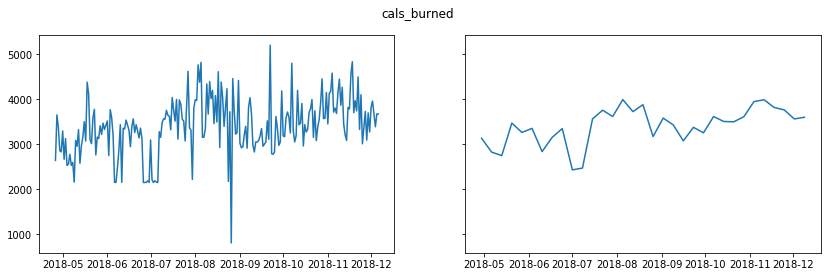

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14,4))
ax1.plot(df.cal_burned.resample("D").mean())
ax2.plot(df.cal_burned.resample("W").mean())
f.suptitle("cals_burned")
f.show()

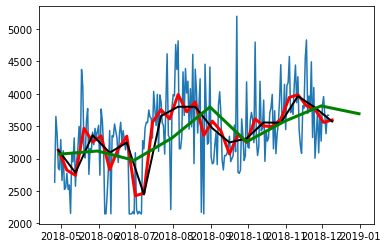

In [81]:
plt.plot(df.cal_burned.resample("D").mean())
plt.plot(df.cal_burned.resample("W").mean(), linewidth=3, c="red")
plt.plot(df.cal_burned.resample("2W").mean(), linewidth=2, c="black")
plt.plot(df.cal_burned.resample("M").mean(), linewidth=3, c="green")

plt.show()

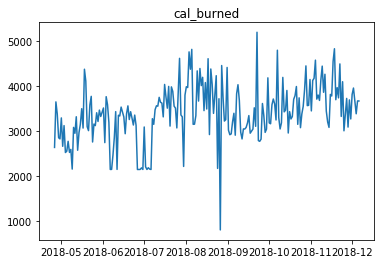

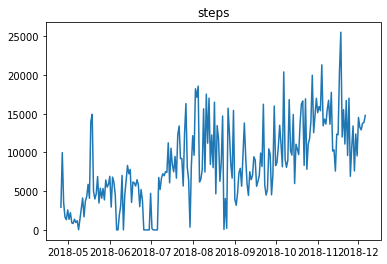

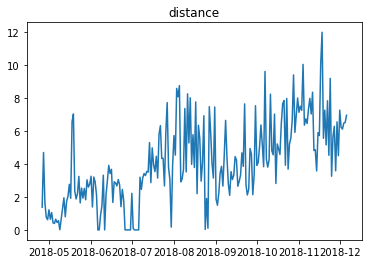

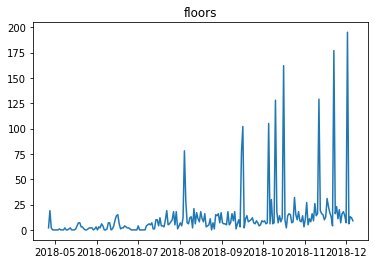

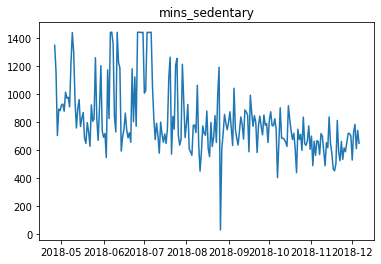

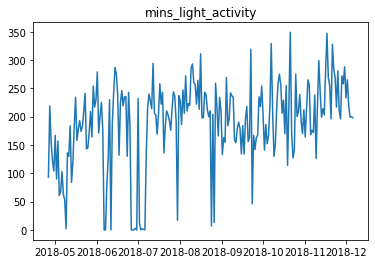

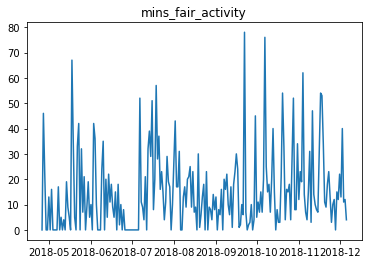

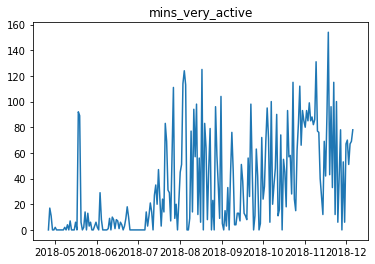

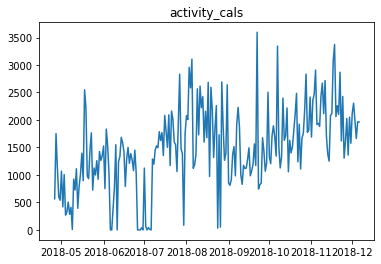

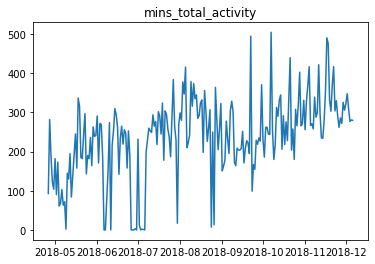

In [15]:
explore.time_series_graphs(df.resample("D").mean())


> - calories burned, steps, distance, floors and activity all increase over time
>- sedetary activity decrease over time

    > This person is getting more active as time increases

In [16]:
df.sort_values(by="cal_burned").head()

,cal_burned,steps,distance,floors,mins_sedentary,mins_light_activity,mins_fair_activity,mins_very_active,activity_cals,mins_total_activity,day
date,,,,,,,,,,,
2018-08-26,799.0,207.0,0.1,1.0,28.0,13.0,0.0,0.0,51.0,13.0,0-Sun
2018-06-26,2144.0,0.0,0.0,0.0,1440.0,0.0,0.0,0.0,0.0,0.0,2-Tue
2018-07-06,2144.0,0.0,0.0,0.0,1440.0,0.0,0.0,0.0,0.0,0.0,5-Fri
2018-07-03,2144.0,0.0,0.0,0.0,1440.0,0.0,0.0,0.0,0.0,0.0,2-Tue
2018-06-28,2145.0,0.0,0.0,0.0,1440.0,0.0,0.0,0.0,0.0,0.0,4-Thu


Found an outlier in row "2018-08-26". It is seen that the calories burned are much lower than the metabolic rate given when the person records no movement at all. Utilized the `fix_outliers` function to replace the 799 calories with 2144 calories. Also replaced the 28 mins of sedentary to 1427 minutes. This is the total minutes (1440) subtracted by the mins of total activity (13) of that day. 

In [17]:
df = prepare.fix_outliers(df)

### Investigate BMR

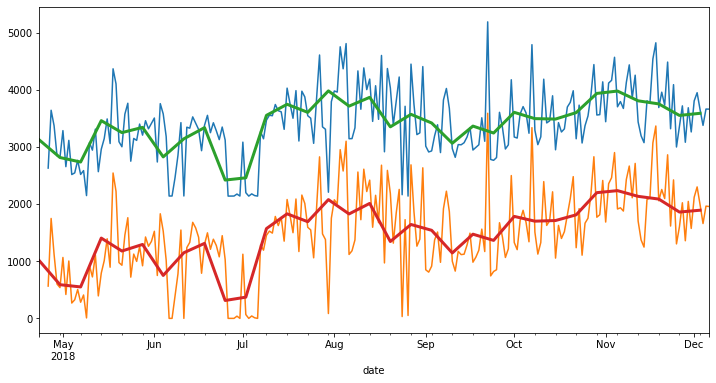

In [95]:
# df[["cal_burned","activity_cals"]].plot(figsize=(12,6))

df.cal_burned.plot(figsize=(12,6))
df.activity_cals.plot()
df.cal_burned.resample("W").mean().plot(linewidth=3)
df.activity_cals.resample("W").mean().plot(linewidth=3)

plt.show()

> It is seen that the calories burned and the activity calories follow the same path. It is determined that this is due to the person's Basal Metabolic Rate (BMR), which puts the calories burned on a pedastal. 

Finding the average calories when the person does not take any steps and has a whole day of sedentary time.

In [20]:
df [(df.steps == 0) & (df.mins_sedentary == 1440)].cal_burned.mean()

2144.8888888888887

It is hypothesized that when the active calories are subtracted from the total calories, the difference will be the BMR of 2145. 

In [21]:
(df.cal_burned - df.activity_cals).mean()

1923.3422222222223

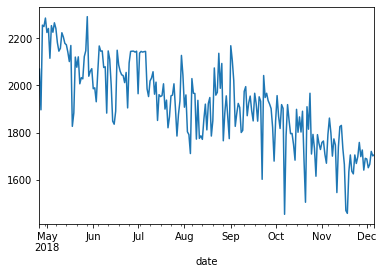

In [22]:
(df.cal_burned - df.activity_cals).plot()
plt.show()

> The BMR is not constant and is decreasing over time. It implies that the person is decreasing their weight. 

### Determine Height

### Trends by Day

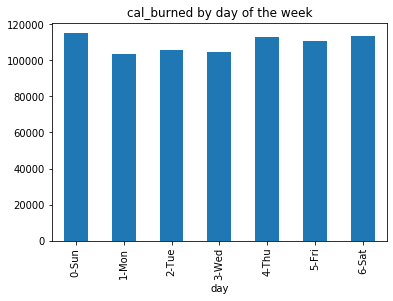

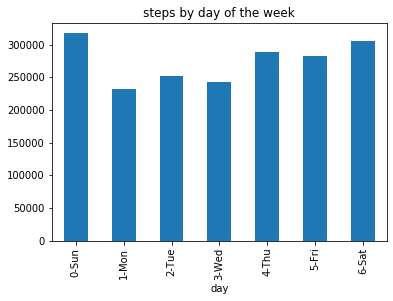

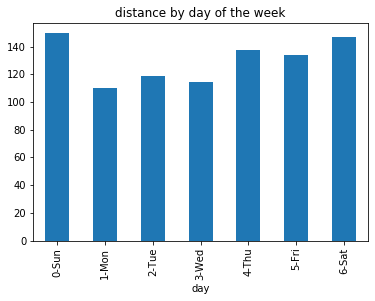

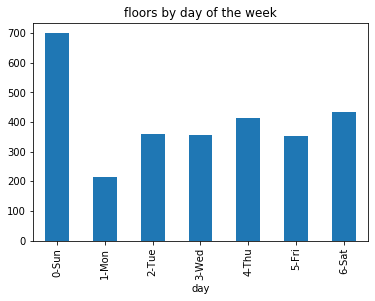

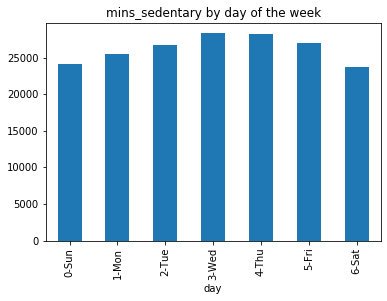

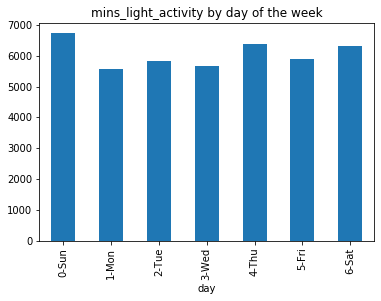

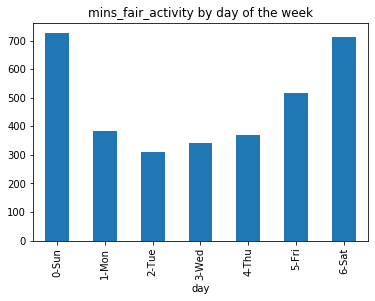

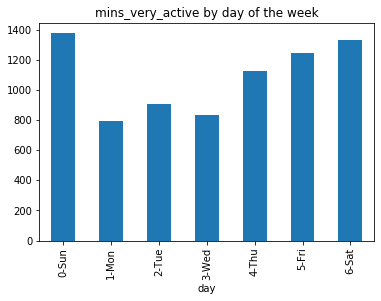

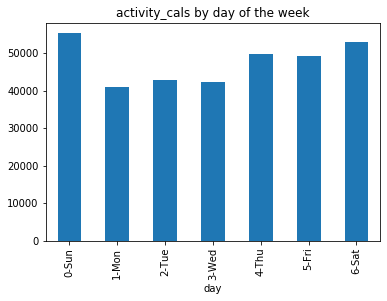

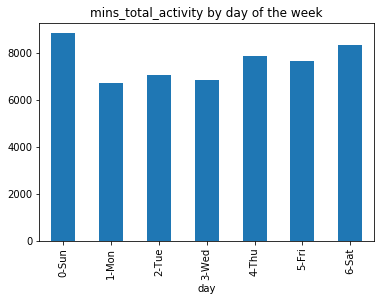

In [23]:
for col in df.select_dtypes(np.number):
    df[col].groupby(df.day).sum().plot.bar()
    plt.title("{} by day of the week".format(col))
    plt.show()

> The highest activity is seen on the weekends. Perhaps they have a desk job and leave their errands for Sundays. However the floors increase drastically on Sundays. Perhaps that is their long walk day.

## VII. Split

Split our data using a cutoff date that is two weeks long

In [71]:
df.tail()

,cal_burned,steps,distance,floors,mins_sedentary,mins_light_activity,mins_fair_activity,mins_very_active,activity_cals,mins_total_activity,day
date,,,,,,,,,,,
2018-12-02,3957.0,13257.0,6.23,195.0,725.0,265.0,13.0,70.0,2305.0,348.0,0-Sun
2018-12-03,3660.0,12915.0,6.12,6.0,782.0,219.0,40.0,51.0,1993.0,310.0,1-Mon
2018-12-04,3384.0,13763.0,6.49,13.0,608.0,199.0,11.0,67.0,1663.0,277.0,2-Tue
2018-12-05,3670.0,13865.0,6.52,12.0,739.0,200.0,12.0,69.0,1968.0,281.0,3-Wed
2018-12-06,3669.0,14774.0,6.96,9.0,647.0,198.0,4.0,78.0,1962.0,280.0,4-Thu


In [96]:
df1 = df.resample("2W").mean()

In [97]:
def split_one_week(df):
    train = df[:'2018-11-25'].resample("W").agg("mean")
    test = df['2018-12-02':].resample("W").agg("mean")
    return train, test

def split_two_week(df):
    train = df1[:'2018-11-25']
    test = df1['2018-12-09':]
    return train, test

In [105]:
train, test = split_one_week(df)

In [106]:
train.tail()

,cal_burned,steps,distance,floors,mins_sedentary,mins_light_activity,mins_fair_activity,mins_very_active,activity_cals,mins_total_activity
date,,,,,,,,,,
2018-10-28,3608.000000,12850.142857,6.060000,14.142857,691.142857,194.714286,19.571429,62.714286,1815.857143,277.000000
2018-11-04,3944.428571,16011.142857,7.552857,11.285714,635.428571,210.285714,23.714286,85.857143,2204.571429,319.857143
2018-11-11,3985.857143,15010.857143,7.182857,31.142857,625.714286,199.714286,17.285714,89.285714,2239.714286,306.285714
2018-11-18,3814.571429,14095.000000,6.708571,18.142857,605.000000,251.000000,25.285714,61.857143,2139.571429,338.142857
2018-11-25,3760.428571,12690.142857,6.117143,37.285714,603.142857,261.428571,15.857143,57.857143,2092.000000,335.142857


In [107]:
test.head()

,cal_burned,steps,distance,floors,mins_sedentary,mins_light_activity,mins_fair_activity,mins_very_active,activity_cals,mins_total_activity
date,,,,,,,,,,
2018-12-02,3957.00,13257.00,6.2300,195.0,725.0,265.0,13.00,70.00,2305.0,348.0
2018-12-09,3595.75,13829.25,6.5225,10.0,694.0,204.0,16.75,66.25,1896.5,287.0


In [108]:
# train, test = split.split_two_weeks(df,'D')

In [109]:
print('Observations: %d' % (len(train.values) + len(test.values)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 33
Training Observations: 31
Testing Observations: 2


Every feature is plotted with their train and test split.

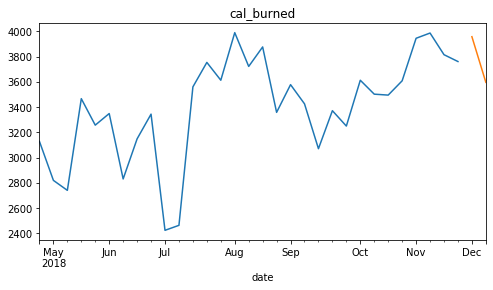

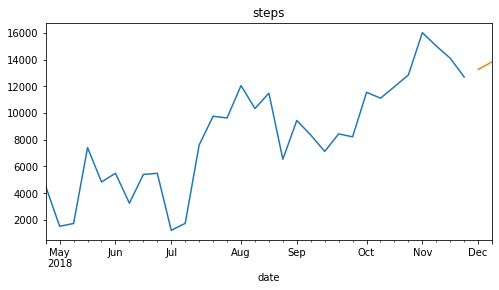

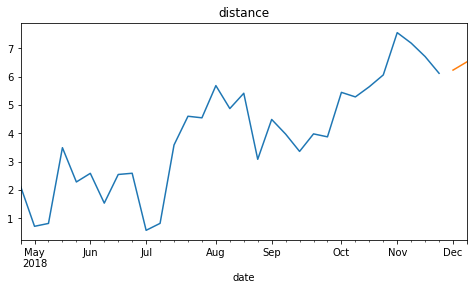

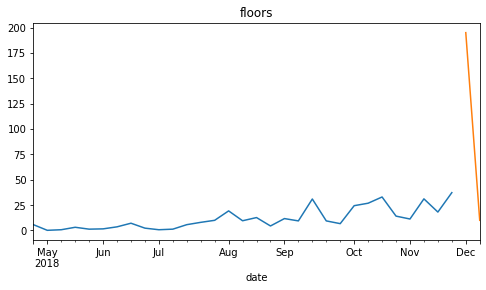

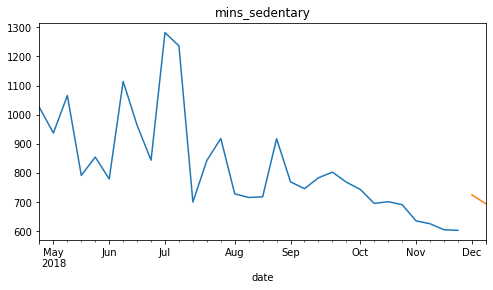

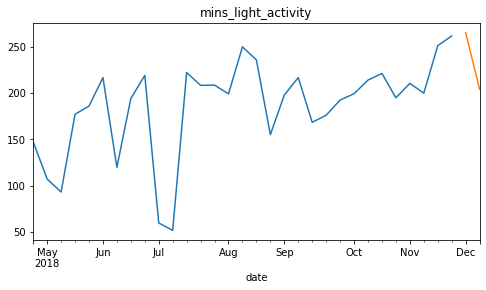

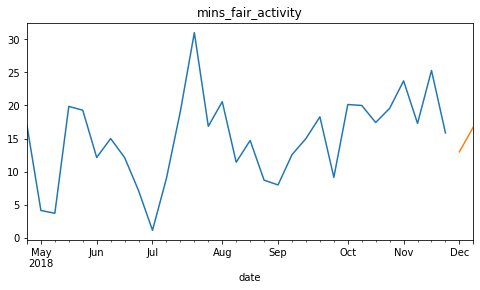

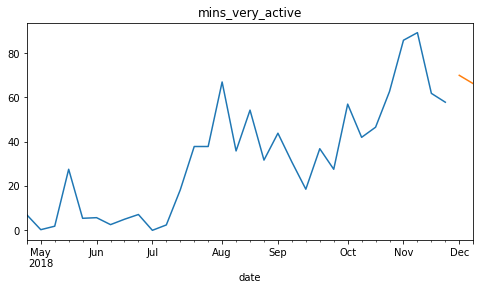

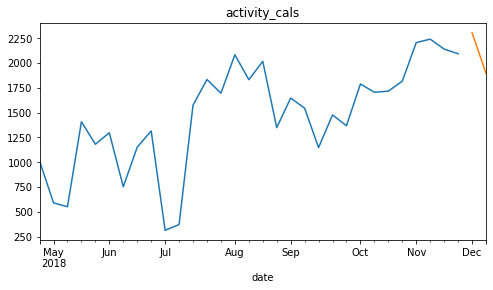

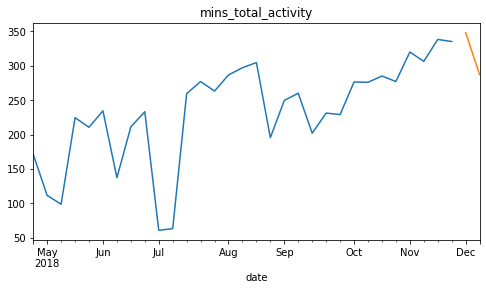

In [110]:
for col in train.columns: 
    plt.figure(figsize=(8, 4))
    train[col].plot()
    test[col].plot()
    plt.title("{}".format(col))
    plt.show()

## VIII. Model

Will test out different models on the data:
- last_value: predicts based on the last value of the dataframe
- simple_avg: predicts based on the average of the whole dataframe
- moving_avg: predicts based on an average of a specified time (30 days in this case) 
- holt: predicts based on adding a second exponential smoothing model 

### Resampling by day

In [42]:
for col in train.columns:
    print(col)
    print(model.run_models(train[col], test[col]))
    print()

cal_burned
   model_type            mse        rmse
0  last_value  983262.214286  991.595792
1  simple_avg  118407.765823  344.104295
2  moving_avg  204561.102063  452.284316
3        holt  402940.015638  634.775563

steps
   model_type           mse         rmse
0  last_value  2.849573e+07  5338.138781
1  simple_avg  2.264120e+07  4758.276728
2  moving_avg  1.341157e+07  3662.180963
3        holt  1.964230e+07  4431.963701

distance
   model_type       mse      rmse
0  last_value  5.859221  2.420583
1  simple_avg  6.330626  2.516073
2  moving_avg  3.137327  1.771250
3        holt  4.297116  2.072949

floors
   model_type           mse        rmse
0  last_value  24951.642857  157.960890
1  simple_avg   2426.347334   49.257967
2  moving_avg   2220.363016   47.120728
3        holt   2210.726439   47.018363

mins_sedentary
   model_type           mse        rmse
0  last_value  23895.714286  154.582387
1  simple_avg  34052.690785  184.533712
2  moving_avg   6314.474921   79.463670
3       

### Resampling by One Week

In [111]:
for col in train.columns:
    print(col)
    print(model.run_models(train[col], test[col]))
    print()

cal_burned
   model_type            mse        rmse
0  last_value   32879.679209  181.327547
1  simple_avg  177536.741142  421.351090
2  moving_avg  170834.959912  413.321860
3        holt   47386.319390  217.683990

steps
   model_type           mse         rmse
0  last_value  8.094461e+05   899.692198
1  simple_avg  2.774257e+07  5267.121198
2  moving_avg  2.643710e+07  5141.701827
3        holt  3.309228e+05   575.258909

distance
   model_type       mse      rmse
0  last_value  0.088526  0.297532
1  simple_avg  6.052459  2.460175
2  moving_avg  5.762490  2.400519
3        holt  0.157486  0.396845

floors
   model_type           mse        rmse
0  last_value  12809.153061  113.177529
1  simple_avg  16805.618973  129.636488
2  moving_avg  16769.787959  129.498216
3        holt  14236.023011  119.314806

mins_sedentary
   model_type           mse        rmse
0  last_value  11552.091837  107.480658
1  simple_avg  13785.133625  117.410109
2  moving_avg  12287.925737  110.850917
3       

### Resampling by Two Weeks

In [101]:
for col in train.columns:
    print(col)
    print(model.run_models(train[col], test[col]))
    print()

cal_burned


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

    > It is determined that the moving average model performs the best overall.

## IX. Findings

- the user of the fitbit is about 6 feet tall
- based on the height, it is most likely that the user is a man
- 

- the user is losing weight over time, based on basal metabolic rate (BMR)